# Vehicle Detection

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Helpers

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    img = img.copy()
    for (x1, y1), (x2, y2) in bboxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thick)
    return img

## Load training data

In [3]:
# TODO describe where to download data

vehicle_images = glob.glob('train_data/vehicles/**/*.png')
print('Vehicles: {}'.format(len(vehicle_images)))

non_vehicle_images = glob.glob('train_data/non-vehicles/**/*.png')
print('Non vehicles: {}'.format(len(vehicle_images)))

Vehicles: 8792
Non vehicles: 8792


## Feature extraction

In [4]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    """
    Binned color features
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

In [5]:
def color_hist(img, nbins=32):     # bins_range=(0, 256)
    """
    Color histogram features
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Histogram of oriented gradient (HOG) features
    """
    if vis:
        hog_features, hog_image = hog(
            img,
            orientations=orient,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            transform_sqrt=False,
            visualise=True,
            feature_vector=feature_vec
        )
        return hog_features, hog_image
    else:      
        hog_features = hog(
            img,
            orientations=orient,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            transform_sqrt=False,
            visualise=False,
            feature_vector=feature_vec
        )
        return hog_features

In [7]:
def single_img_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a list to append feature vectors to
    img_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    # Return concatenated array of features
    if vis:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

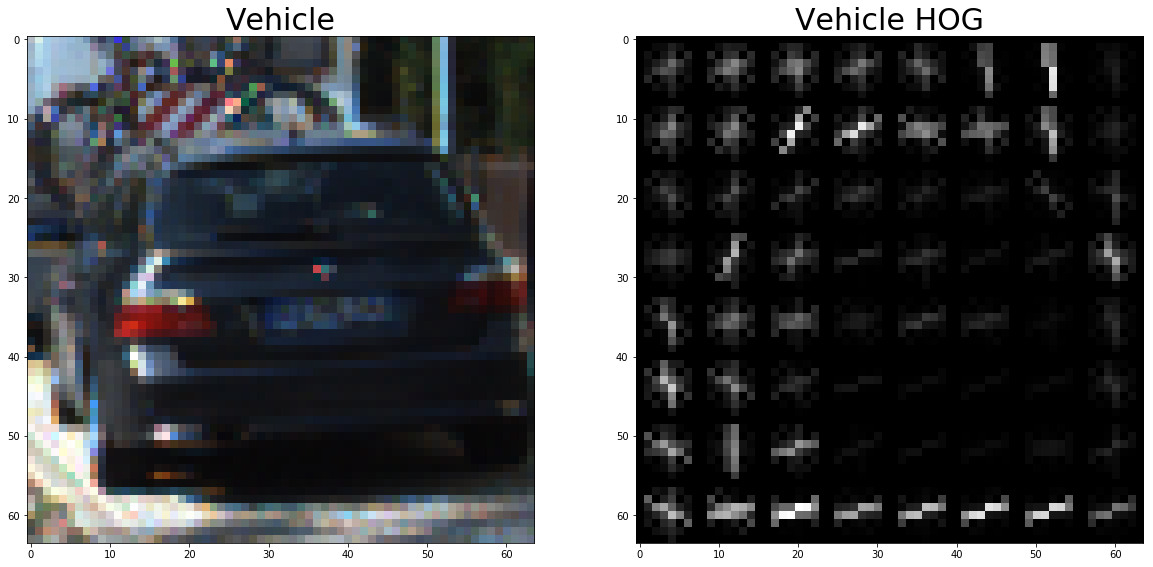

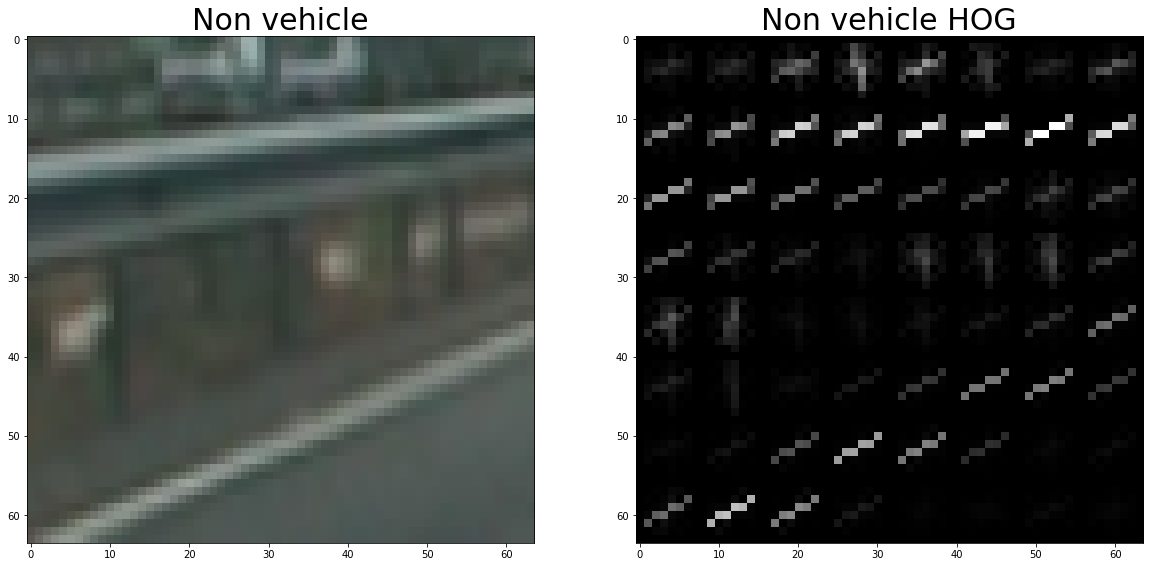

In [8]:
vehicle_image = mpimg.imread(random.choice(vehicle_images))
non_vehicle_image = mpimg.imread(random.choice(non_vehicle_images))

vehicle_features, vehicle_hog_image = single_img_features(
    vehicle_image,
    color_space='YCrCb',
    spatial_size=(32, 32),
    hist_bins=32,
    orient=11,
    pix_per_cell=8,
    cell_per_block=2,
    hog_channel=0,
    spatial_feat=True,
    hist_feat=True,
    hog_feat=True,
    vis=True
)    

non_vehicle_features, non_vehicle_hog_image = single_img_features(
    non_vehicle_image,
    color_space='YCrCb',
    spatial_size=(32, 32),
    hist_bins=32,
    orient=11,
    pix_per_cell=8,
    cell_per_block=2,
    hog_channel=0,
    spatial_feat=True,
    hist_feat=True,
    hog_feat=True,
    vis=True
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(vehicle_image, cmap='gray')
ax1.set_title('Vehicle', fontsize=30)
ax2.imshow(vehicle_hog_image, cmap='gray')
ax2.set_title('Vehicle HOG', fontsize=30)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(non_vehicle_image, cmap='gray')
ax1.set_title('Non vehicle', fontsize=30)
ax2.imshow(non_vehicle_hog_image, cmap='gray')
ax2.set_title('Non vehicle HOG', fontsize=30)

In [9]:
def extract_features(img_files, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_files:
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis=False)
        features.append(img_features)
    # Return list of feature vectors
    return features

## Sliding window

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

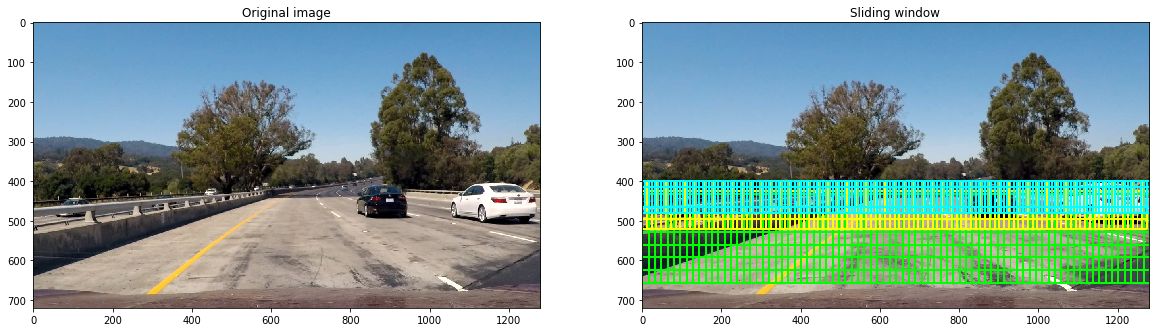

In [11]:
test_img = mpimg.imread('test_images/test1.jpg')

# Using scale = 2.0, window = 128x128
windows = slide_window(
    test_img,
    x_start_stop=[None, None],
    y_start_stop=[400, 656],
    xy_window=(128, 128),
    xy_overlap=(0.875, 0.75)
)
draw_img = draw_boxes(test_img, windows, color=(0, 255, 0), thick=4)
    
# Using scale = 1.5, window = 96x96
windows = slide_window(
    test_img,
    x_start_stop=[None, None],
    y_start_stop=[400, 528],
    xy_window=(96, 96),
    xy_overlap=(0.875, 0.75)
)
draw_img = draw_boxes(draw_img, windows, color=(255, 255, 0), thick=4)
    
# Using scale = 1.0, window = 64x64
windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 480], xy_window=(64, 64), xy_overlap=(0.875, 0.75))
draw_img = draw_boxes(draw_img, windows, color=(0, 255, 255), thick=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original image', fontsize=12)
ax2.imshow(draw_img)
ax2.set_title('Sliding window', fontsize=12)

## Classifier

In [12]:
def define_classifier(cars, notcars, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    print('Using:', orient, 'orientations,', pix_per_cell, 'pixels per cell,', cell_per_block, 'cells per block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
    
    t=time.time()
    
    car_features = extract_features(
        cars,
        color_space=color_space,
        spatial_size=spatial_size,
        hist_bins=hist_bins,
        orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel=hog_channel,
        spatial_feat=spatial_feat,
        hist_feat=hist_feat,
        hog_feat=hog_feat
    )    

    notcar_features = extract_features(
        notcars,
        color_space=color_space,
        spatial_size=spatial_size,
        hist_bins=hist_bins, orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel=hog_channel,
        spatial_feat=spatial_feat,
        hist_feat=hist_feat,
        hog_feat=hog_feat
    )    

    t2 = time.time()
    print(round((t2-t), 2), 'seconds to compute features...')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return X_scaler, scaled_X, y

In [13]:
X_scaler, scaled_X, y = define_classifier(
    vehicle_images,
    non_vehicle_images,
    color_space='YCrCb',
    spatial_size=(32, 32),
    hist_bins=32,
    orient=11,
    pix_per_cell=8,
    cell_per_block=2,
    hog_channel='ALL',
    spatial_feat=True,
    hist_feat=True,
    hog_feat=True
)

Using: 11 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
129.61 seconds to compute features...


## Training

In [14]:
def train_classifier(scaled_X, y):
    rand_state = np.random.randint(0,100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC
    parameters = {'C':[0.01, 0.001, 0.0001]}
    svr =  LinearSVC()
    svc = GridSearchCV(svr, parameters)

    # Check the training time for the SVC
    t = time.time()

    svc.fit(X_train, y_train)

    t2 = time.time()
    print(round((t2-t), 2), 'seconds to train SVC...')

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print('Best params:', svc.best_params_)

    return svc, f

In [15]:
svc, f = train_classifier(scaled_X, y)

Feature vector length: 9636
106.17 seconds to train SVC...
Test Accuracy of SVC =  0.9916
Best params: {'C': 0.0001}


## Pipeline

In [16]:
def find_cars(img, scale, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    img_boxes = []
    t = time.time()
    draw_img = np.copy(img)
    # Uncomment when img is jpg & training data is png
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))  
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 1 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # This will give you a series of HOG window extracts
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return draw_img, img_boxes

In [17]:
def add_heat(heatmap, windows):
    for window in windows:
        heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1
        #heatmap = 255 * heatmap / np.max(heatmap)
    return heatmap

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [30]:
def make_pipeline(show_heatmap=False):
    def pipeline(img):
        threshold = 3

        draw_img1, img_boxes1 = find_cars(
            img, 1., 400, 480, svc, X_scaler,
            orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32
        )
        draw_img2, img_boxes2 = find_cars(
            img, 1.5, 400, 528, svc, X_scaler,
            orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32
        )
        draw_img3, img_boxes3 = find_cars(
            img, 2., 400, 656, svc, X_scaler,
            orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32
        )

        # Consolidate results
        draw_img = cv2.add(draw_img1, draw_img2, draw_img3)
        img_boxes = img_boxes1 + img_boxes2 + img_boxes3

        # Add heatmap
        heatmap = np.zeros_like(img[:,:,0])
        heatmap = add_heat(heatmap, img_boxes)
        heatmap = apply_threshold(heatmap, threshold)

        # Label areas and place in boxes
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        if show_heatmap:
            return draw_img, heatmap
        else:
            return draw_img

    return pipeline

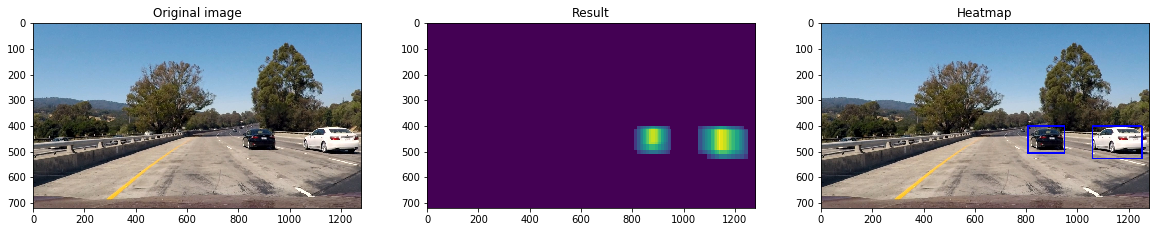

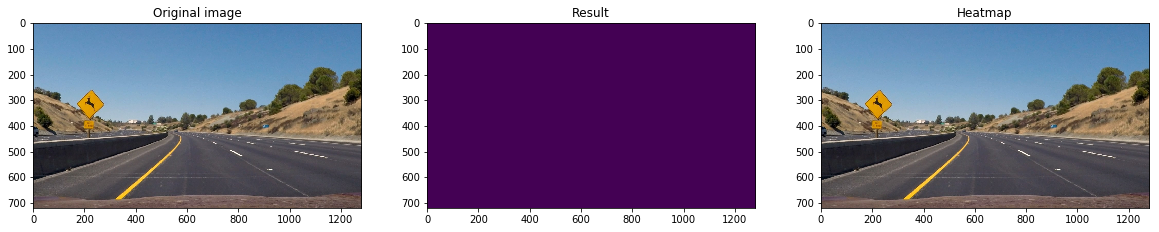

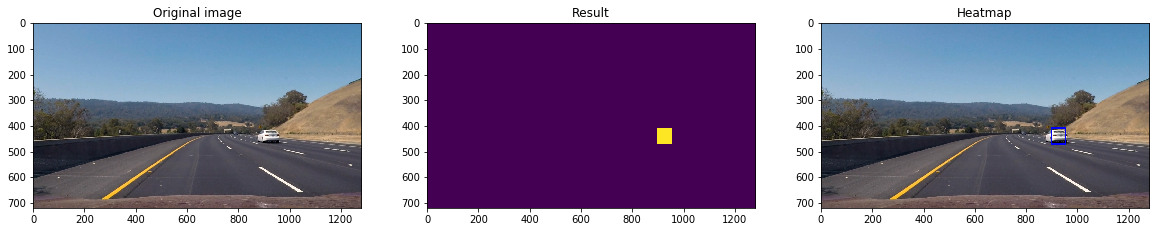

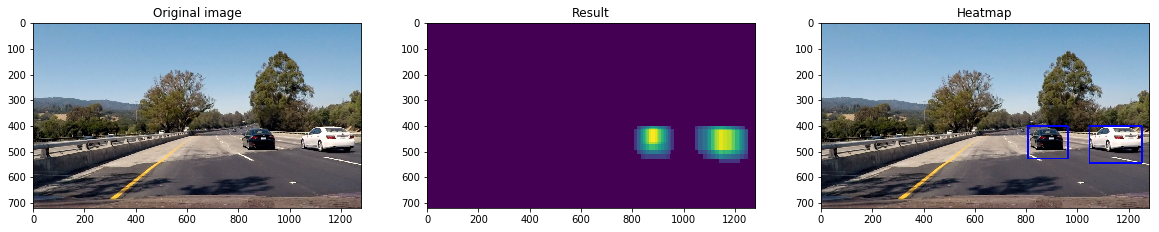

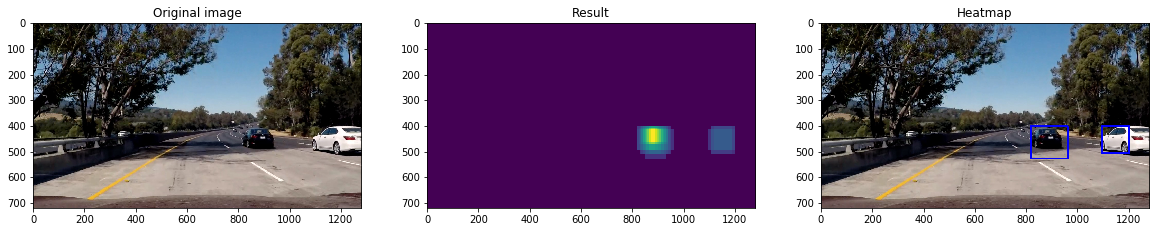

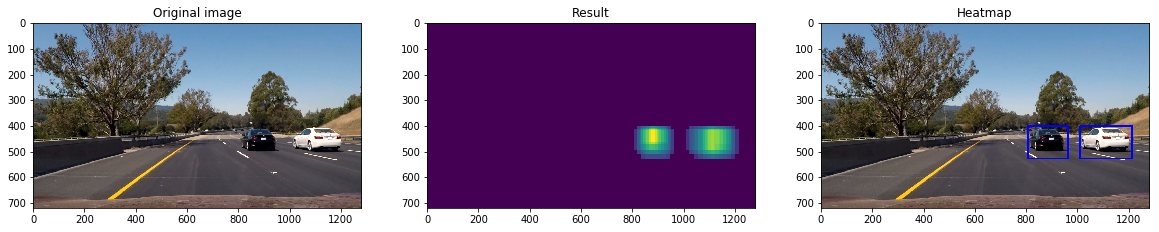

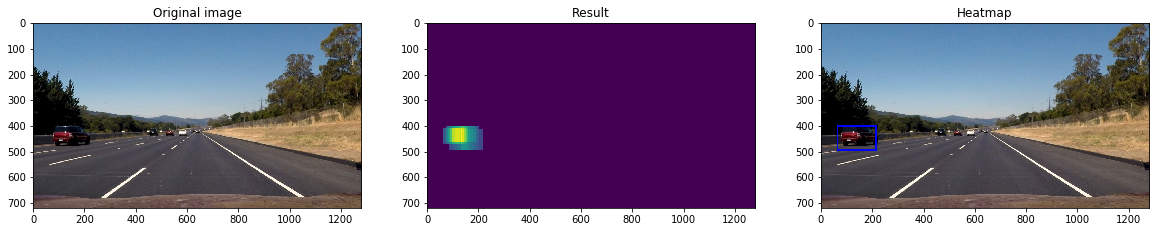

In [31]:
test_images = glob.glob('test_images/test*.jpg')
test_pipeline = make_pipeline(show_heatmap=True)

for img_file in test_images:
    img = mpimg.imread(img_file)
    draw_img, heatmap = test_pipeline(img)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original image', fontsize=12)
    ax2.imshow(heatmap)
    ax2.set_title('Result', fontsize=12)
    ax3.imshow(draw_img)
    ax3.set_title('Heatmap', fontsize=12)

## Video

In [32]:
video_output = 'output.mp4'
clip = VideoFileClip("project_video.mp4")
result_clip = clip.fl_image(make_pipeline())
%time result_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



 62%|██████▏   | 155/251 [03:07<01:39,  1.03s/it]


100%|█████████▉| 250/251 [04:46<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 52s, sys: 340 ms, total: 4min 52s
Wall time: 4min 48s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))